In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import style
from scipy.stats import norm

# Styles
style.use('fivethirtyeight')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['font.size'] = 18

In [2]:
# Functions
#https://dfrieds.com/data-visualizations/how-format-large-tick-values.html

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [3]:
# Load Data
df = pd.read_excel("Sample - Superstore.xls")
df = df.set_index('Order Date')
sales = df['Sales'].resample('W').sum()

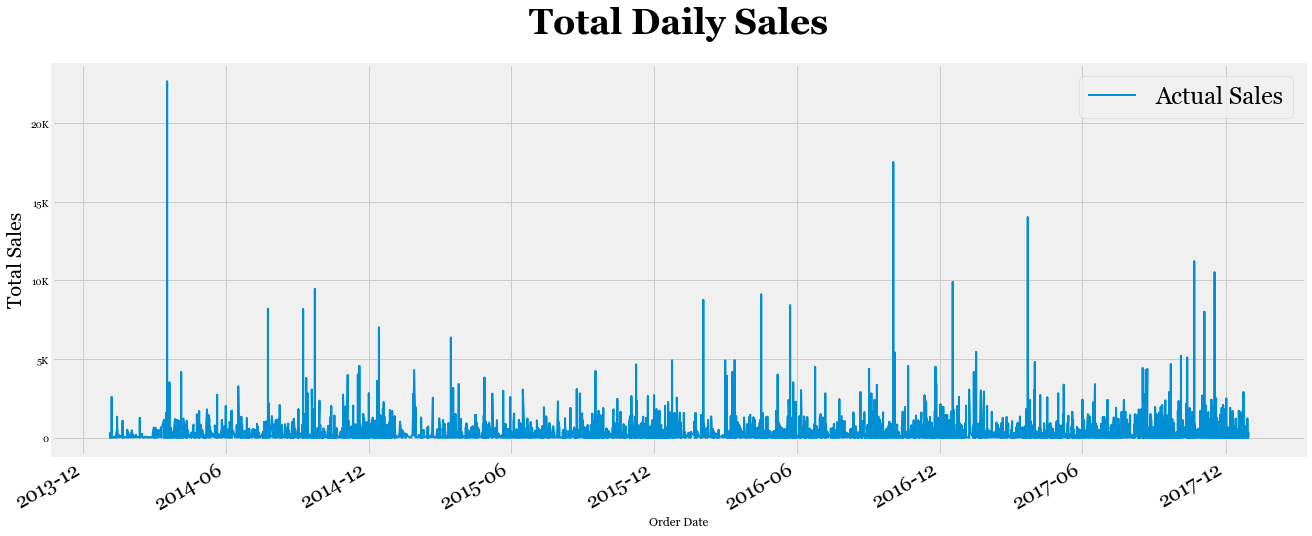

In [4]:
# Sales
smoothed = sales.rolling(window=6).mean()
smoothed = smoothed.dropna()

fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('Total Daily Sales', fontsize=35, fontweight='bold', pad=30)
ax.set_ylabel('Total Sales', fontsize=20)
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

for t in ax.xaxis.get_major_ticks():
    t.label.set_fontsize(20) 

df['Sales'].plot(ax=ax, linewidth=2, label="Actual Sales")
ax.legend(fontsize=24)

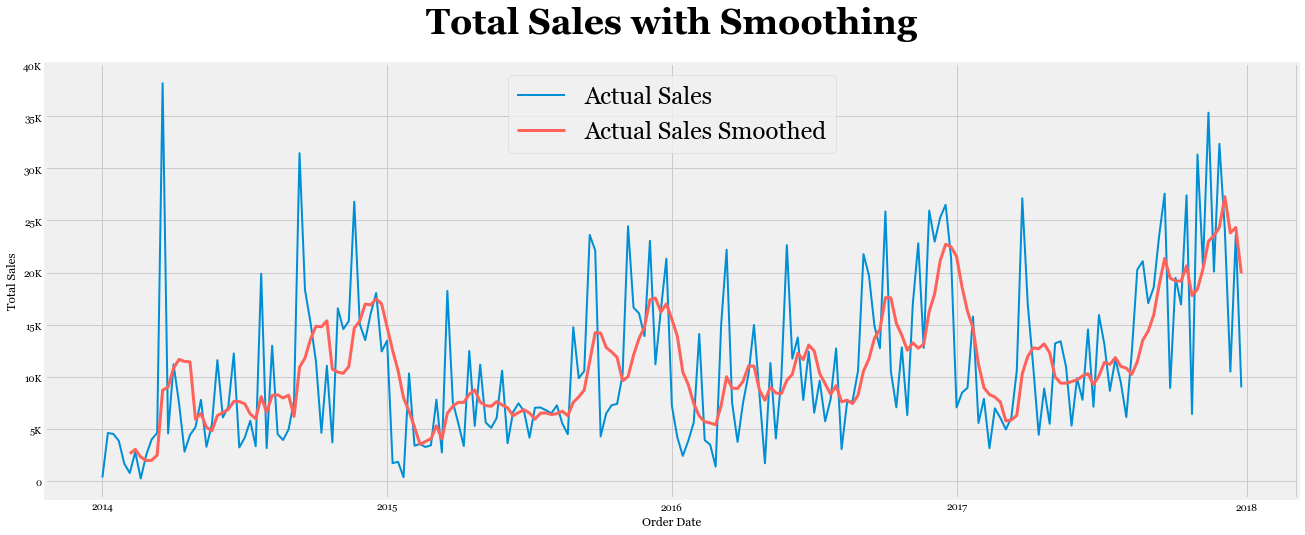

In [5]:
# Total Sales with Smoothing
smoothed = sales.rolling(window=6).mean()
smoothed = smoothed.dropna()

fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('Total Sales with Smoothing', fontsize=35, fontweight='bold', pad=30)
ax.set_ylabel('Total Sales')
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sales.plot(ax=ax, linewidth=2, label="Actual Sales")
smoothed.plot(ax=ax, linewidth=3, color='#FF625B', label="Actual Sales Smoothed")
#ax.legend([plt1, plt2], ['Actual Sales', 'Actual Sales Smoothed'])
ax.legend(fontsize=24)

Text(0.5,1,'Distribution of Weekly Sales')

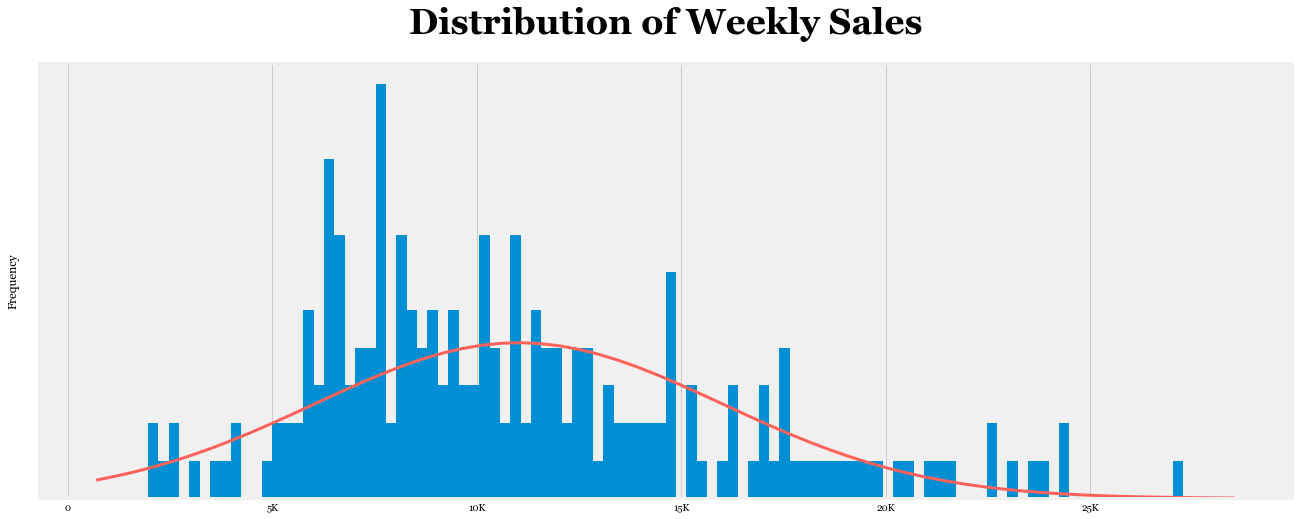

In [6]:
# Distribution of Weekly Sales
fig, ax = plt.subplots(figsize=(20,8))

smoothed.plot.hist(bins=100, density=True, ax=ax)

# Plot the pdf
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, smoothed.mean(), smoothed.std())
ax.plot(x, p, color='#FF625B', linewidth=3)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

ax.set_yticks([])
ax.set_ylabel('Frequency', labelpad=20)
ax.set_title('Distribution of Weekly Sales', fontsize=35, fontweight='bold', pad=30)

Text(0.5,1.05,'Simulate Random Walks')

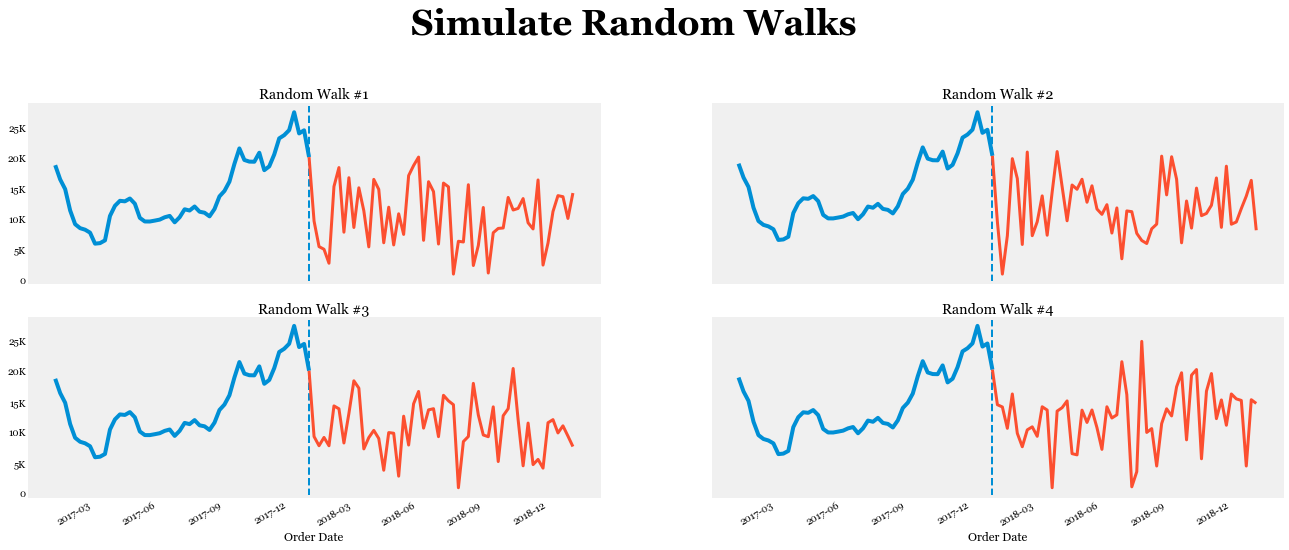

In [7]:
# A random walk
last_sale = smoothed[-1]
num_weeks = 53

mu = smoothed.mean()
std = smoothed.std()

index = pd.date_range('2017-12-31', periods=54, freq='W')

def make_sim_plot(ax=ax, title=''):
    sales_series = []
    sales_series.append(last_sale)

    for week in range(num_weeks):
        weekly_sales = np.random.normal(mu, std)
        if weekly_sales < 0:
            weekly_sales = 0
        sales_series.append(weekly_sales)
    s = pd.Series(sales_series, index=index)
    ax.set_title(title)
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    ax.axvline(x=s.index.min(), linestyle='dashed', linewidth=2)

    smoothed[-52:].plot(ax=ax)
    s.plot(ax=ax, linewidth=3)

    
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize=(20,8))

make_sim_plot(ax1, title='Random Walk #1')
make_sim_plot(ax2, title='Random Walk #2')
make_sim_plot(ax3, title='Random Walk #3')
make_sim_plot(ax4, title='Random Walk #4')
ax2.set_yticks([])
ax4.set_yticks([])
ax2.set_xticks([])
ax2.set_xlabel('')
ax1.set_xticks([])
ax1.set_xlabel('')

ax1.grid(None)
ax2.grid(None)
ax3.grid(None)
ax4.grid(None)

fig.suptitle('Simulate Random Walks', fontsize=35, fontweight='bold', y=1.05)

Text(0.5,0.98,'Simulations of 1,000 Random Walks')

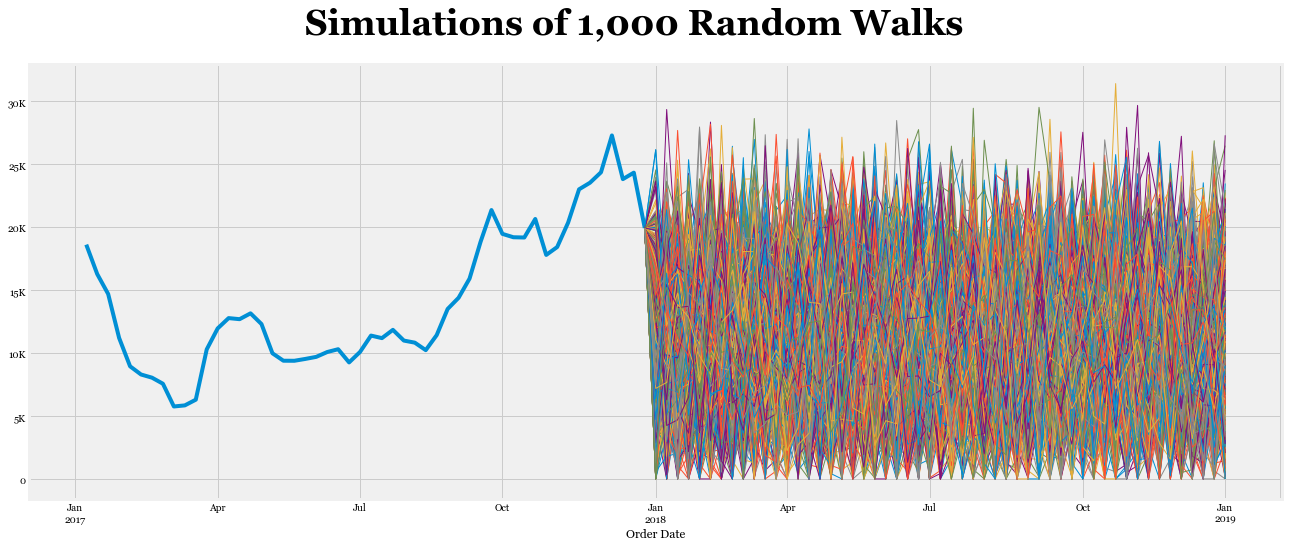

In [8]:
# Many, many random walks
num_simulations = 1000
num_weeks = 53

last_sale = smoothed[-1]
mu = smoothed.mean()
std = smoothed.std()

index = pd.date_range('2017-12-31', periods=54, freq='W')

simulation_df = pd.DataFrame()

sales_2018 = []

for sim in range(num_simulations):
    sales_series = []
    sales_series.append(last_sale)

    for week in range(num_weeks):
        weekly_sales = np.random.normal(mu, std)
        if weekly_sales < 0:
            weekly_sales = 0
        sales_series.append(weekly_sales)
    
    sales_2018.append(np.sum(sales_series))
    simulation_df[sim] = sales_series

simulation_df.index = index

fig, ax = plt.subplots(figsize=(20,8))
smoothed[-52:].plot(ax=ax)
simulation_df.plot(ax=ax, legend=False, linewidth=1)

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
fig.suptitle('Simulations of 1,000 Random Walks', fontsize=35, fontweight='bold')

Text(0.5,0.98,'Total 2018 Sales Simulation')

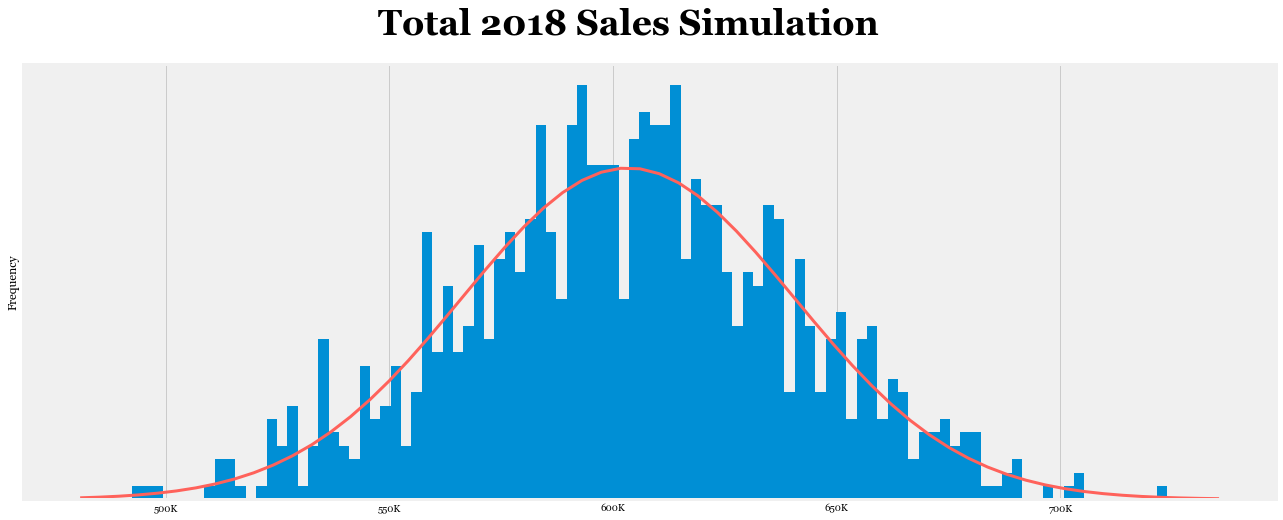

In [9]:
#Random walk total sales

fig, ax = plt.subplots(figsize=(20,8))
simulations_2018 = pd.Series(data=sales_2018)
simulations_2018.plot.hist(bins=100, ax=ax, density=True)

# Plot the pdf
xmin, xmax = plt.xlim()
mean = simulations_2018.mean()
std = simulations_2018.std()

x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, mean, std)
ax.plot(x, p, color='#FF625B', linewidth=3)
ax.set_yticks([])
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
fig.suptitle('Total 2018 Sales Simulation', fontsize=35, fontweight='bold')

Text(0.5,0.98,'2018 Total Sales Normal Distribution')

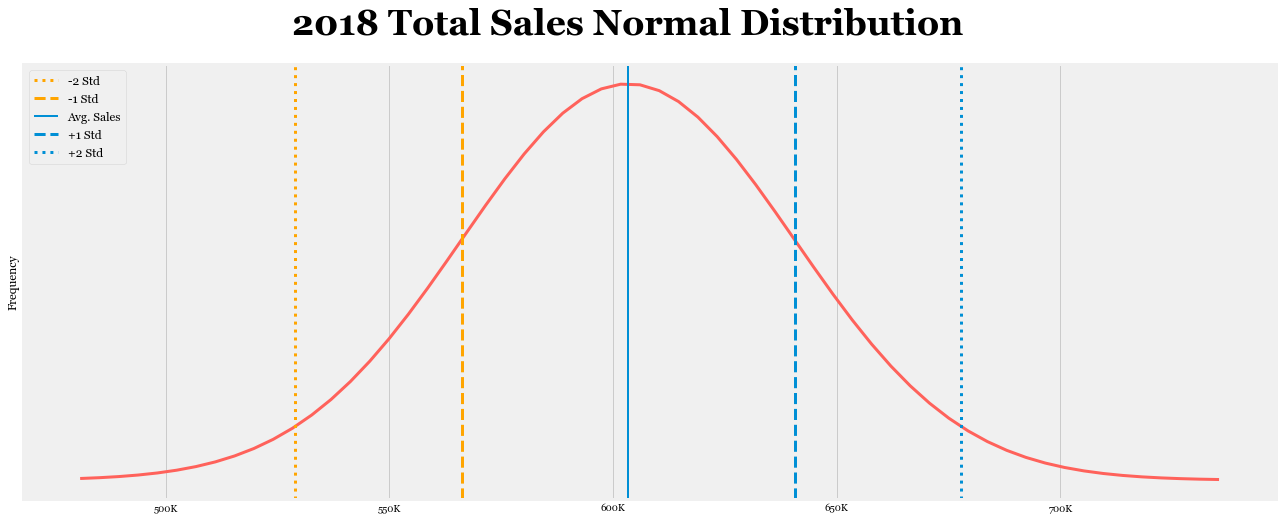

In [10]:
# 2018 Sales normal distribution
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(x, p, color='#FF625B', linewidth=3)

ax.set_yticks([])
ax.set_ylabel('Frequency')

ax.axvline(mean - (std * 2), linewidth=3, label='-2 Std', linestyle='dotted', color='orange')
ax.axvline(mean - std, linewidth=3, label='-1 Std', linestyle='dashed', color='orange')
ax.axvline(mean, linewidth=2, label="Avg. Sales")
ax.axvline(mean + std, linewidth=3, label='+1 Std', linestyle='dashed')
ax.axvline(mean + (std * 2), linewidth=3, label='+2 Std', linestyle='dotted')

ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.legend(fontsize=12, loc='upper left')
fig.suptitle('2018 Total Sales Normal Distribution', fontsize=35, fontweight='bold')

In [11]:
# Ask Questions

from scipy.stats import norm
#mean + std * norm.
#mean + (std * norm.ppf(.25))
print("It's highly likely that you sales will be between ${:,.0f} and ${:,.0f}.".format(mean + (2 * -std), mean + (2 * std)))
print("There's a 25% chance that sales will be less than {:,.0f}.".format(mean + (std * norm.ppf(.25))))

It's highly likely that you sales will be between $528,884 and $677,838.
There's a 25% chance that sales will be less than 578,244.
